In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

# Sythetic data: exploration and development

**TODOs**

1. amend the ~~stays'~~[segments] endpoints to coincide with the sparse stays
    * **Note** check that the new stays don't violate the duration criteria; fix?
2. improve the duplication for the data
    * $\checkmark$ **Goal** have parameterizable duplicates from parameterizable events
        * two returns
            * $\checkmark$ ~~specify the number (or fraction) of sampled events~~
            * ~~specify a random range of the number of sampled events~~
        * $\checkmark$ ~~for each of the above returns, specify the fraction of data to be duplicated~~
        
    * Extensions:
        * include some specific $x$-locations which are duplicated in certain segments
            * this is like a tower which is pinged multiple times but only gives it's location
        * include some specific $\Delta x$'s which are duplicated showing an effecitve radius when triangulation fails
        * segement-/location-specific noise
            * try also with the array of weights passed in `np.random.choice`
                * changes the probab. of picking up specific events in the full array


In [5]:
import os, sys

In [6]:
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [7]:
from synthetic_data.trajectory import get_stay_paths, get_journey_path, get_segments

In [8]:
from synthetic_data.noise import get_noise

In [9]:
from synthetic_data.trajectory import get_stay_segs, get_stay, get_seg_info, get_trav

## Journey segments

### times

In [10]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

### the stays

**Notes**
* specify the beginning and ends of stays, along with location (_ie_ $t_0, t_1, x$, resp.)
* travels connect the endpoints adjacent stays

In [71]:
from synthetic_data.trajectory import get_stay

stays = [
        get_stay(  0.00,  8.00,-1.00), #home
        get_stay(  8.50, 12.00, 1.10), #work, morning
        get_stay( 12.25, 13.25, 1.60), #lunch
        get_stay( 13.50, 18.00, 1.10), #work, afternoon
        get_stay( 18.50, 20.30,-0.50), #gym
        get_stay( 20.50, 21.50,-2.00), #shopping
        get_stay( 22.00, 24.00, 0.00)  # overnight
    ]

### from stays, get travels, segments, and journey

In [72]:
from synthetic_data.masking import get_mask
from synthetic_data.noise import get_noise

t_segs, x_segs = get_stay_segs(stays)

raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))

### More realistic trajectory 

Here, time points can be repeated, as in mobile phone trajectories based on apparent simultaneous events

**Notes** 
1. Want 1 parameter: fraction of duplicates
2. Problem is that some events get duplicated uniformly 
    * it would be better to have a few events multiply duplicated
        * _ie_ `[0,1,1,2,3,4,5,6,7,7,8...]` vs. `[0,1,1,1,1,2,3,4,5,6,7,7,7,...]`

To get duplicated events
1. select a subset of timepoints for sparsification
2. select a subset from this to be the core duplicates
    * each timespoint will have at least one duplicate
    * _all_ duplicates will come from this subset
3. iteratively sample from this subset until fraction is achieved


In [15]:
from synthetic_data.masking import get_mask_with_duplicates

In [73]:
dup_mask = get_mask_with_duplicates(time, 0.005, 0.6, True)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]
print(time_sub.size)

172
Counter({1: 65, 2: 26, 3: 8, 4: 5, 5: 1, 6: 1})
freq 106 172 106

344 172 172 50.0
344


### Changing the stay limits to account for the masked data

In [74]:
from synthetic_data.trajectory import get_adjusted_stays

In [75]:
segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)        

### Applying the noise

In [160]:
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [161]:
noises = get_noise_arr(0.01, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

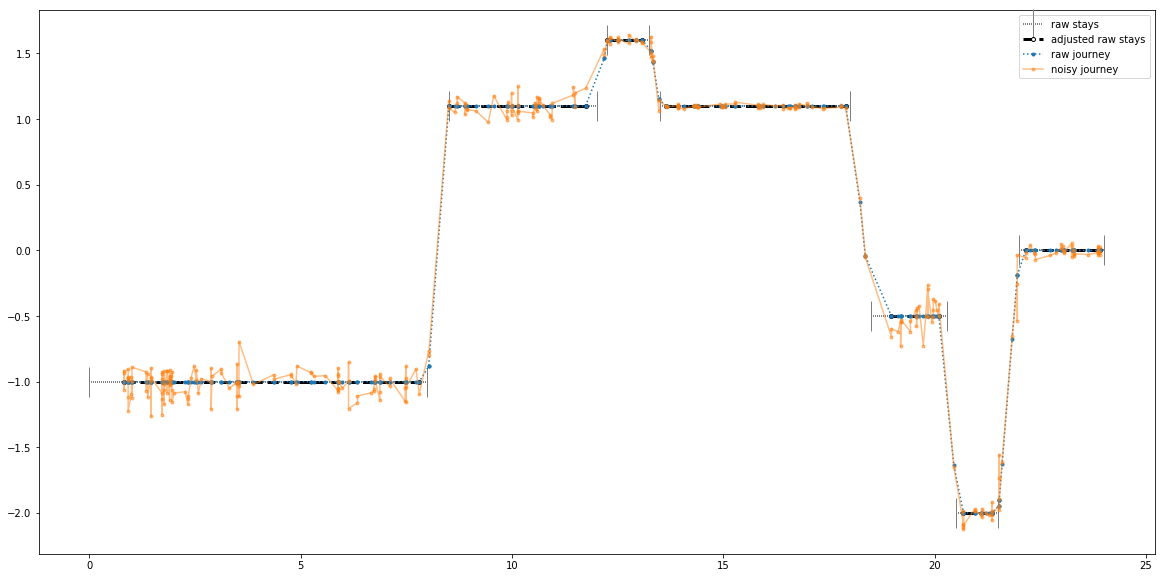

In [168]:
plt.figure(figsize=(20,10))
plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, '.:', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
#plt.xlim(9,12)
plt.legend();

In [171]:
from synthetic_data.trajectory import get_stay

stays = [
        get_stay(  0.00,  8.00,-1.00), #home
        get_stay(  8.50, 18.00, 1.00), #work, afternoon
        get_stay( 19.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))

dup_mask = get_mask_with_duplicates(time, 0.005, 0.6, True)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.01, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

172
Counter({1: 61, 2: 28, 3: 15, 5: 2})
freq 106 172 106

344 172 172 50.0


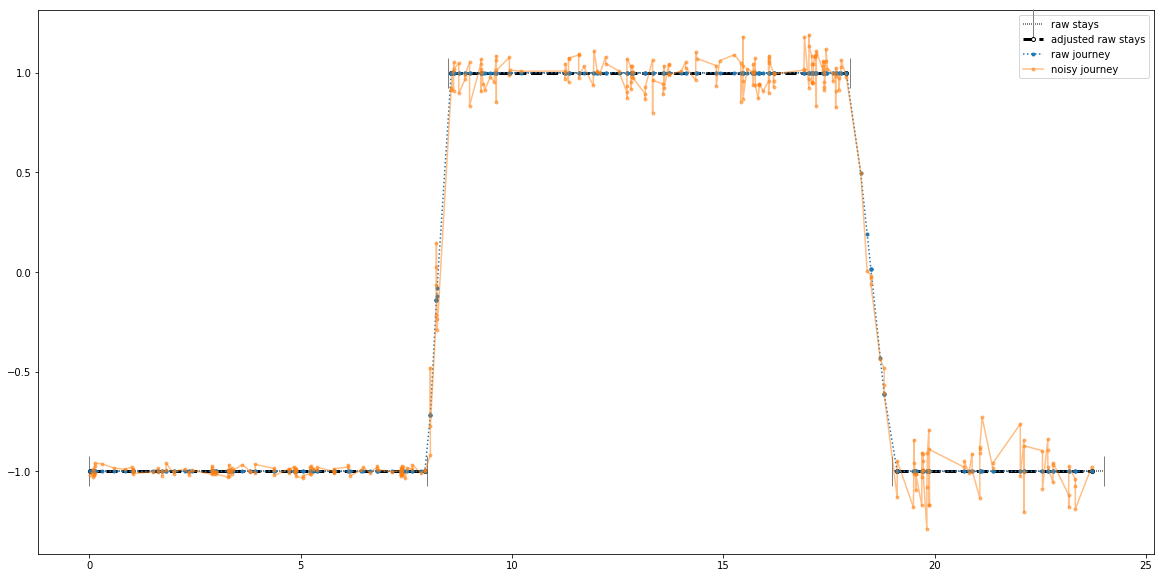

In [172]:
plt.figure(figsize=(20,10))
plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, '.:', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
#plt.xlim(9,12)
plt.legend();